##### Questoin > Supervisor > LLM Or RAG 

In [1]:
pip install langchain_groq sentence_transformers faiss-cpu pydantic python-dotenv pypdf bs4 langchain langchain_core langchain-community langchain_huggingface langchain_google_genai langchain-pinecone langgraph langchain-openai langchain_groq langchain_google_genai google-generativeai  pymupdf wikipedia arxiv defusedxml  youtube_search langchain-tavily langgraph chromadb langchain[chromadb]


zsh:1: no matches found: langchain[chromadb]
Note: you may need to restart the kernel to use updated packages.


In [2]:
#### import
import os
from dotenv import load_dotenv
from langgraph.graph import Graph
from IPython.display import Image, display
load_dotenv()


True

In [3]:
#from langchain_google_genai import ChatGoogleGenerativeAI
#model=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash')
from langchain_groq import ChatGroq
model= ChatGroq(model="deepseek-r1-distill-llama-70b")
output=model.invoke('Great Day !! ')
print(output.content)

<think>

</think>

Great day to you as well! How can I assist you today?


#### Configure the embdeeing Model

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("Hi"))

/Users/anvvsharma/anvv/ws/agenticai/vagenticai/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


384

##### Lets take a Data embedd it and store in Vector Database

In [7]:
##### Imports
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
from langchain_core.tools import tool
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END,MessagesState,START
from langgraph.prebuilt import ToolNode


##### 
#####   ``` This is the workflow with tool calling ```
#####   ```Binding the tool to the LLM /  ```
#####   ```Note: Model Use some good model for agentic workflow , as opensource model might not give the correct output ```
#####   ```Testing a llm_with_tool  ```


In [8]:
@tool
def search(query:str):
    """This is my Custom Tool for earching a weather"""
    if "delhi" in query.lower():
        return "the temperature is 45 degree and sunny "
    else:
        return "the temp is 25 degree and cloudy"

In [9]:
search.invoke("what is the Temperate in Hyderabad")
tools = [search]
llm_with_tool = model.bind_tools(tools)
response = llm_with_tool.invoke("what is the weather in delhi")
print(response)
response.tool_calls

content='' additional_kwargs={'tool_calls': [{'id': 'gpznegq2x', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 133, 'total_tokens': 232, 'completion_time': 0.391002197, 'prompt_time': 0.008578188, 'queue_time': 0.054174226000000006, 'total_time': 0.399580385}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ab22121e-18b6-4299-acd8-b6804c591c97-0' tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'gpznegq2x', 'type': 'tool_call'}] usage_metadata={'input_tokens': 133, 'output_tokens': 99, 'total_tokens': 232}


[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': 'gpznegq2x',
  'type': 'tool_call'}]

In [10]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}
'''
def call_model(state: MessagesState):
    message = state['messages'][-1]
    if isinstance(message, HumanMessage):
        question_text = message.content
    else:
        question_text = str(message)
    question = HumanMessage(content=question_text)
    print(f"This is your question message: {question}")
    response = model.invoke([question])
    
    return {"messages": [response.content]}    
'''    

'\ndef call_model(state: MessagesState):\n    message = state[\'messages\'][-1]\n    if isinstance(message, HumanMessage):\n        question_text = message.content\n    else:\n        question_text = str(message)\n    question = HumanMessage(content=question_text)\n    print(f"This is your question message: {question}")\n    response = model.invoke([question])\n\n    return {"messages": [response.content]}    \n'

In [13]:
input={"messages":["what is a weather in delhi?"]}
response = call_model(input)
response["messages"][-1].content
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in Delhi'},
  'id': '6rzj8a83b',
  'type': 'tool_call'}]

In [14]:
def router_function(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [15]:
tools

[StructuredTool(name='search', description='This is my Custom Tool for earching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x10cd865c0>)]

In [16]:
tool_node=ToolNode(tools)

#### Define workflow

In [30]:
mytools = "MyTools"
workflow2=StateGraph(MessagesState)
workflow2.add_node("llm_with_tool", call_model)
workflow2.add_node(mytools, tool_node)
workflow2.add_edge(START, "llm_with_tool")
workflow2.add_conditional_edges("llm_with_tool", router_function, {"tools": mytools, END:END})

In [31]:
app2=workflow2.compile()

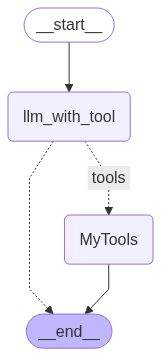

In [32]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

##### Testing the App

In [33]:
app2.invoke({"messages":["what is a weather in bengraluru?"]})

{'messages': [HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='b335297f-8abe-4aad-9f5d-c9a45a6d3173'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '09r82tesd', 'function': {'arguments': '{"query":"Bengaluru weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 136, 'total_tokens': 269, 'completion_time': 0.557226098, 'prompt_time': 0.008688224, 'queue_time': 0.053954016, 'total_time': 0.565914322}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--70d1f0fd-f87e-4f56-9677-abc6b86d375c-0', tool_calls=[{'name': 'search', 'args': {'query': 'Bengaluru weather'}, 'id': '09r82tesd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 136, 'output_tokens': 133, 'total_tokens': 269}),
  ToolMessage(content='the temp is 25 degree and cloudy', name

In [34]:
app2.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='d3925fa1-021c-444c-bfb1-9ccfa83d3a4a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fr6fm4f0q', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 158, 'prompt_tokens': 134, 'total_tokens': 292, 'completion_time': 0.75037259, 'prompt_time': 0.008563668, 'queue_time': 0.058098552, 'total_time': 0.758936258}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9a9f81e-8944-4006-a214-2b23d82ddfd8-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'fr6fm4f0q', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 158, 'total_tokens': 292}),
  ToolMessage(content='the temperature is 45 degree and sunny ', name=

In [35]:
app2.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='4e972b2c-1e80-4bf0-99e4-7e11bf673bfb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'smegnz4bb', 'function': {'arguments': '{"query":"weather in Paris"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 525, 'prompt_tokens': 131, 'total_tokens': 656, 'completion_time': 2.213222538, 'prompt_time': 0.008448651, 'queue_time': 0.057294309, 'total_time': 2.221671189}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b447f8f8-f429-42b9-816b-16ebb40d4f60-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Paris'}, 'id': 'smegnz4bb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 525, 'total_tokens': 656}),
  ToolMessage(content='the temp is 25 degree and cloudy', name='search', id='4c11

In [36]:
##### Final Answer 
response["messages"][-1].content

''

In [42]:
#### 
workflow2.add_edge(mytools,"llm_with_tool")
app3=workflow2.compile()


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


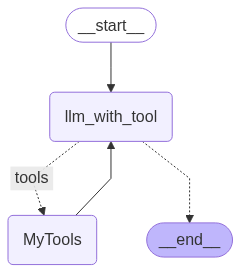

In [43]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [47]:
#### Calling steam you will get response from each tool
for output in app3.stream({"messages":["what is a weather in new delhi?"]}):
    for key, value in output.items():
        print(f"here is the output {key}")
        print("_______")
        print(value)
        print("\n")


here is the output llm_with_tool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ffnw36v8p', 'function': {'arguments': '{"query":"weather in New Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 135, 'total_tokens': 210, 'completion_time': 0.277482209, 'prompt_time': 0.008689351, 'queue_time': 0.05817177900000001, 'total_time': 0.28617156}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0f18a26e-b118-4897-a6ea-24bf9e24444e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in New Delhi'}, 'id': 'ffnw36v8p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 75, 'total_tokens': 210})]}


here is the output MyTools
_______
{'messages': [ToolMessage(content='the temperature is 45 degree and sunny ', name='search', id='19211ed4-0061-45be-9542

In [48]:
#### # Memory class in langchain
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [50]:
workflow3=StateGraph(MessagesState)
workflow3.add_node("llm_with_tool",call_model)
workflow3.add_node(mytools,tool_node)
workflow3.add_edge(START,"llm_with_tool")
workflow3.add_conditional_edges("llm_with_tool",
                                router_function,
                                {"tools":mytools,
                                 END:END})
workflow3.add_edge(mytools,"llm_with_tool")

In [51]:
app4=workflow3.compile(checkpointer=memory)

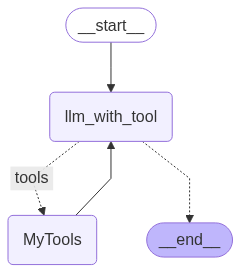

In [52]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [53]:
config={"configurable": {"thread_id": "1"}}
events=app4.stream(
    {"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values"
    )
for event in events:
    event["messages"][-1].pretty_print()
        

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  search (qy961xa7h)
 Call ID: qy961xa7h
  Args:
    query: weather in New Delhi
================================= Tool Message =================================
Name: search

the temperature is 45 degree and sunny 
================================== Ai Message ==================================

The current weather in New Delhi is 45 degrees and sunny. Make sure to stay hydrated and use sunscreen if you're going outside!


In [54]:
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  search (5bedbw7mq)
 Call ID: 5bedbw7mq
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy
================================== Ai Message ==================================
Tool Calls:
  search (mck5n5x86)
 Call ID: mck5n5x86
  Args:
    query: weather in Indore
================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy
================================== Ai Message ==================================

The temperature in Indore is **25 degrees** and the weather is **cloudy**.


In [55]:
config

{'configurable': {'thread_id': '1'}}

In [56]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T18:47:26.674113+00:00',
 'id': '1f049500-44b5-61a6-800a-18059465922c',
 'channel_versions': {'__start__': '00000000000000000000000000000007.0.4199276226614974',
  'messages': '00000000000000000000000000000012.0.2156460152694466',
  'branch:to:llm_with_tool': '00000000000000000000000000000012.0.5639211849244408',
  'branch:to:MyTools': '00000000000000000000000000000011.0.0820491091813369'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.6448793578144616'},
  'llm_with_tool': {'branch:to:llm_with_tool': '00000000000000000000000000000011.0.1319456798626959'},
  'MyTools': {'branch:to:MyTools': '00000000000000000000000000000010.0.26522125954548126'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='be7629df-4d10-4fd6-903c-9d93ed32c3bc'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qy961xa7h', 'funct

In [57]:
events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )
for event in events:
    event["messages"][-1].pretty_print()
    memory.get(config)

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The temperature was 25 degrees in **Indore**.


In [59]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-14T18:48:30.954632+00:00',
 'id': '1f049502-a9bb-6f4e-800d-311207161080',
 'channel_versions': {'__start__': '00000000000000000000000000000014.0.890358141824959',
  'messages': '00000000000000000000000000000015.0.556359723391595',
  'branch:to:llm_with_tool': '00000000000000000000000000000015.0.1877719460074052',
  'branch:to:MyTools': '00000000000000000000000000000011.0.0820491091813369'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000013.0.18713084057201945'},
  'llm_with_tool': {'branch:to:llm_with_tool': '00000000000000000000000000000014.0.7639846947777081'},
  'MyTools': {'branch:to:MyTools': '00000000000000000000000000000010.0.26522125954548126'}},
 'channel_values': {'messages': [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='be7629df-4d10-4fd6-903c-9d93ed32c3bc'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qy961xa7h', 'functi